
# Autoregressive Integrated Moving Average(ARIMA) Model


Importing all the required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Loading Datasets

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/Testdata_new.csv', encoding = "ISO-8859-1" )
df_test.head()

,date,AQI
0,05-01-16,102.333333
1,12-01-16,116.666667
2,16-01-16,112.666667
3,22-01-16,116.666667
4,29-01-16,110.000000


Dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/CleanedDataset.csv', encoding = "ISO-8859-1" )
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,4.8,17.4,NaN,0.0,NaN,0.0,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial,3.1,7.0,NaN,0.0,NaN,0.0,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,6.2,28.5,NaN,0.0,NaN,0.0,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,RRO,6.3,14.7,NaN,0.0,NaN,0.0,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial,4.7,7.5,NaN,0.0,NaN,0.0,1990-03-01


Adding new column 'year' in the dataframe 

In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') # date parse
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(df["year"].min())
df['year'] = df['year'].values.astype(int)


Eliminating the null entries

In [ ]:
def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total / len(df) * 100
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")

In [ ]:
printNullValues(df)

                              Total    Percent
agency                       130937  34.316408
stn_code                     126544  33.165076
location_monitoring_station   21038   5.513710
type                           4145   1.086335
rspm                            904   0.236923
-------------


In [ ]:
df["type"].value_counts()

RRO           243087
Industrial    120599
Sensitive      13727
Name: type, dtype: int64

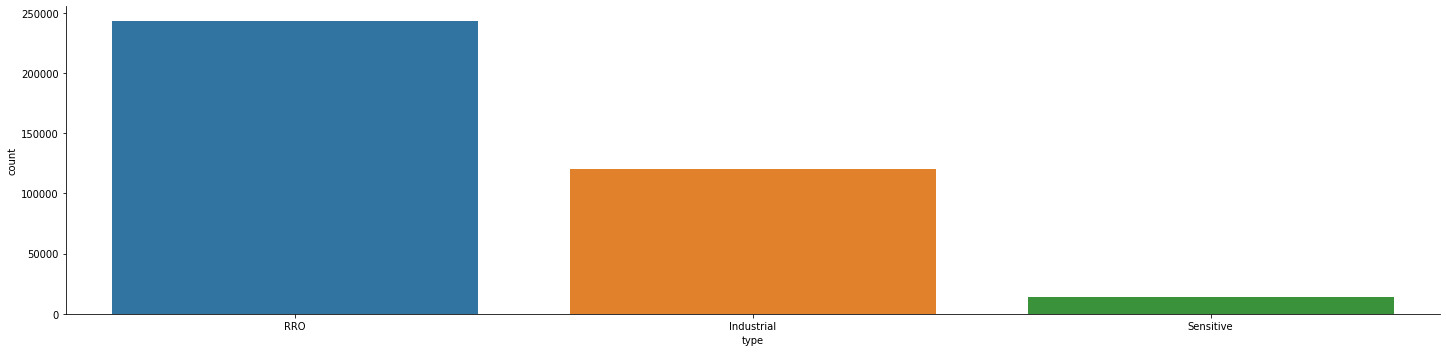

In [ ]:
sns.catplot(x = "type", kind = "count",  data = df, height=5, aspect = 4)

# Air Quality Index Calculation from concentration of given pollutants

Function to calculate so2 individual pollutant index(si)

In [ ]:
def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
    
df['si']=df['so2'].apply(calculate_si)
data= df[['so2','si']]
data.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


Function to calculate no2 individual pollutant index(ni)

In [ ]:
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
df['ni']=df['no2'].apply(calculate_ni)
data= df[['no2','ni']]
data.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


Function to calculate rspm individual pollutant index(rpi)

In [ ]:
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
     rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
     rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
     rpi=300+(rpi-120)*(100/130)
    else:
     rpi=400+(rpi-250)*(100/130)
    return rpi
df['rpi']=df['rspm'].apply(calculate_si)
data= df[['rspm','rpi']]
data.tail()

,rspm,rpi
381553,148.0,122.666667
381554,131.0,117.000000
381555,140.0,120.000000
381556,143.0,121.000000
381557,171.0,130.333333


Function to calculate spm individual pollutant index(spm)

In [ ]:
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi
df['spi']=df['spm'].apply(calculate_spi)
data= df[['spm','spi']]
data.tail()

,spm,spi
381553,0.0,0.0
381554,0.0,0.0
381555,0.0,0.0
381556,0.0,0.0
381557,0.0,0.0


Function to calculate the air quality index (AQI) of every data value.
It is calculated as per the indian government standards.

In [ ]:
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi
df['AQI']=df.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
data= df[['sampling_date','state','si','ni','rpi','spi','AQI']]
data.head()

,sampling_date,state,si,ni,rpi,spi,AQI
0,February - M021990,Andhra Pradesh,6.000,21.750,0.0,0.0,21.750
1,February - M021990,Andhra Pradesh,3.875,8.750,0.0,0.0,8.750
2,February - M021990,Andhra Pradesh,7.750,35.625,0.0,0.0,35.625
3,March - M031990,Andhra Pradesh,7.875,18.375,0.0,0.0,18.375
4,March - M031990,Andhra Pradesh,5.875,9.375,0.0,0.0,9.375


Grouping data on date, year and state.

In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') # date parse
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(0.0).astype(int)
df = df[(df['year']>0)]

data = df[['date','year','state','AQI']].groupby(["date","year","state"]).median().reset_index().sort_values(by=['year','state'],ascending=True)
data.head()

,date,year,state,AQI
57,1987-01-12,1987,Bihar,150.000000
109,1987-02-09,1987,Bihar,171.000000
150,1987-03-07,1987,Bihar,146.000000
188,1987-04-12,1987,Bihar,291.000000
216,1987-07-28,1987,Bihar,121.333333


#Madhya Pradesh

Making a new dataframe consisting data of state Madhya Pradesh

In [ ]:
#Madhya Pradesh
df_mp = df[['date','year','state','AQI']].groupby(["date","year","state"]).median().reset_index().sort_values(by=['year','state'],ascending=False)
df_mp= df.loc[(df.state=="Madhya Pradesh"),["date","year","AQI"]]  
df_mp.head()
#df_mp.count()

,date,year,AQI
164954,1988-06-13,1988,212.000000
164955,1988-02-06,1988,222.000000
164956,1988-01-07,1988,73.750000
164957,1988-01-10,1988,113.333333
164958,1988-01-10,1988,223.000000


Eliminating the null entries.

In [ ]:
df_mp=df_mp.dropna()
df_mp.describe()

,year,AQI
count,17933.000000,17933.000000
mean,2008.682708,143.887721
std,5.238206,85.406860
min,1988.000000,0.000000
25%,2006.000000,101.000000
50%,2009.000000,122.000000
75%,2013.000000,173.333333
max,2015.000000,910.000000


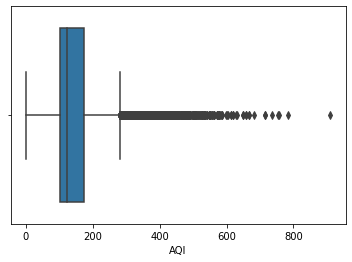

In [ ]:
import seaborn as sns
sns.boxplot(x=df_mp['AQI'])

Removing Outliers

In [ ]:
#removing Outliers
df_mp = df_mp[np.isfinite(df_mp['AQI'])]
df_mp=df_mp[df_mp.AQI >101]
df_mp=df_mp[df_mp.AQI <174]
df_mp.head()
# df_mp.count()

,date,year,AQI
164957,1988-01-10,1988,113.333333
164960,1988-02-11,1988,126.666667
164967,1989-01-01,1989,105.333333
164970,1989-01-01,1989,134.000000
164973,1989-02-01,1989,123.333333


Create a new dataframe consisting of only two columns date and its respective AQI and set date as the new index.

In [ ]:
df_mp = df_mp[["date", "AQI"]]
X = df_mp.values
size = int(len(X) * 0.80)
df1 = pd.DataFrame(df_mp[size:len(X)])
df_mp = df_mp.set_index("date")
df_mp = df_mp.dropna()
#len(df_mp)
#df_mp = df_mp.iloc[::-1]
df_mp.head()

,AQI
date,
1988-01-10,113.333333
1988-02-11,126.666667
1989-01-01,105.333333
1989-01-01,134.000000
1989-02-01,123.333333


Analysing ARIMA model on the dataset.

 Dickey Fuller Test

In [ ]:
test_result=adfuller(df_mp['AQI'])

In [ ]:
def adfuller_test(aqi):
    result=adfuller(aqi)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df_mp['AQI'])

ADF Test Statistic : -7.155010478991961
p-value : 3.0708387026126273e-10
#Lags Used : 37
Number of Observations Used : 8919
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


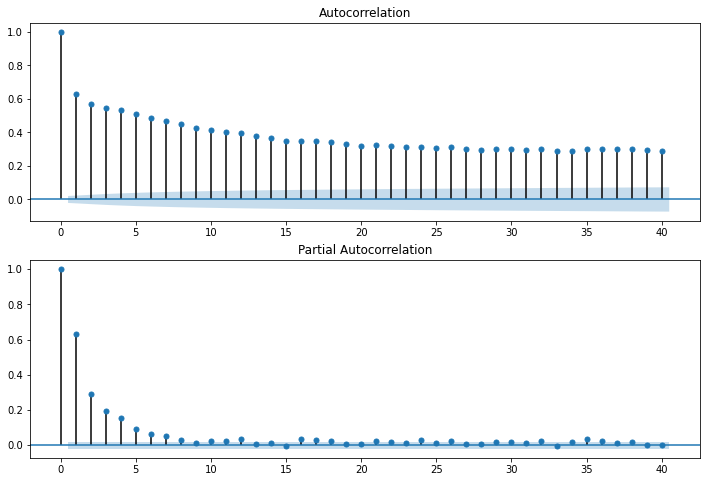

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mp.iloc[23:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mp.iloc[13:],lags=40,ax=ax2)

                             ARIMA Model Results                              
Dep. Variable:                  D.AQI   No. Observations:                 8956
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -36544.582
Method:                       css-mle   S.D. of innovations             14.317
Date:                Wed, 27 May 2020   AIC                          73097.164
Time:                        04:35:25   BIC                          73125.565
Sample:                             1   HQIC                         73106.831
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0008      0.037     -0.022      0.982      -0.074       0.072
ma.L1.D.AQI    -0.6547      0.010    -63.396      0.000      -0.675      -0.634
ma.L2.D.AQI    -0.0991      0.011     -8.960    

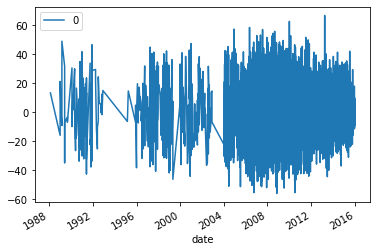

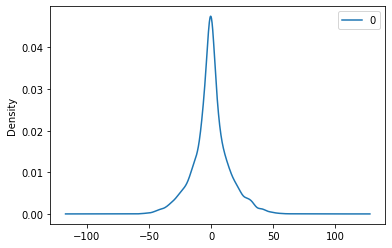

                 0
count  8956.000000
mean      0.002883
std      14.319006
min     -55.913286
25%      -6.676942
50%      -0.151249
75%       6.478169
max      66.685457


In [ ]:
# fit model
model = ARIMA(df_mp['AQI'], order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
df1 = pd.DataFrame(df_mp[size:len(X)])
Y = df1.values

Spliting Dataset into training and testing data in the ratio 80:20. 

In [ ]:
X = df_mp.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
i=0
for t in range(len(test)):
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=105.326516, expected=104.666667
predicted=105.576891, expected=102.333333
predicted=104.916121, expected=101.333333
predicted=104.610776, expected=101.666667
predicted=104.383961, expected=102.666667
predicted=104.572327, expected=103.333333
predicted=104.584536, expected=109.666667
predicted=106.849840, expected=115.000000
predicted=109.547900, expected=136.000000
predicted=117.974577, expected=120.333333
predicted=116.952136, expected=111.666667
predicted=114.993523, expected=134.000000
predicted=121.849752, expected=117.666667
predicted=118.597965, expected=116.333333
predicted=116.666710, expected=116.333333
predicted=116.206359, expected=101.333333
predicted=111.122482, expected=116.333333
predicted=112.948245, expected=104.000000
predicted=109.255144, expected=109.000000
predicted=109.417801, expected=108.666667
predicted=109.175181, expected=119.333333
predicted=112.761708, expected=135.000000
predicted=119.277129, expected=113.000000
predicted=115.387183, expected=138

In [ ]:
prediction_df = pd.DataFrame(predictions,columns =['predicted AQI']) 
prediction_df

,predicted AQI
0,103.495906
1,103.836998
2,103.205695
3,102.716031
4,102.543141
...,...
1787,112.944307
1788,114.536728
1789,114.589138
1790,114.321681


Model output on Testing data.

In [ ]:
df1 = df1.reset_index(drop=True)
prediction_df = prediction_df.reset_index(drop=True)
result = pd.merge(left=df1,right=prediction_df, left_index=True, right_index=True)
result

,AQI,predicted AQI
0,104.666667,103.495906
1,102.333333,103.836998
2,101.333333,103.205695
3,101.666667,102.716031
4,102.666667,102.543141
...,...,...
1787,118.666667,112.944307
1788,116.333333,114.536728
1789,114.333333,114.589138
1790,115.333333,114.321681


Mean Absolute Error

In [ ]:
mae_error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae_error)

Test MAE: 5.050


Root Mean Square Error

In [ ]:
rmse = sqrt(error)
print('Root Mean Squared Error: %.3f' % rmse)

Root Mean Squared Error: 7.579


Mean Absolute Percentage Error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
 mean_absolute_percentage_error(test,predictions)

4.237927925845683

Graph between actual and predicted AQI

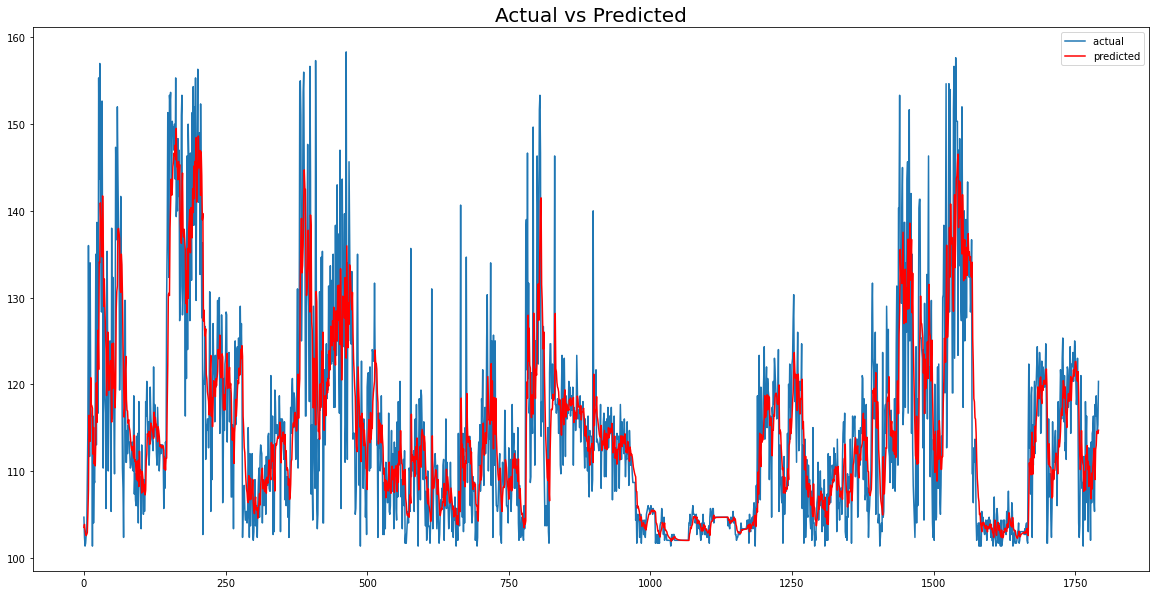

In [ ]:
# plot
fig= plt.figure(figsize=(20,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("Actual vs Predicted",fontsize=20)
plt.legend(["actual ","predicted"])
plt.show()

#Testing model on testcases

In [ ]:
df2 = df_test
df_test = df_test.set_index("date")
df_test = df_test.dropna()

In [ ]:
test_result=adfuller(df_test['AQI'])

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(aqi):
    result=adfuller(aqi)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df_test['AQI'])

ADF Test Statistic : -5.658476253881409
p-value : 9.499718549582557e-07
#Lags Used : 2
Number of Observations Used : 628
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


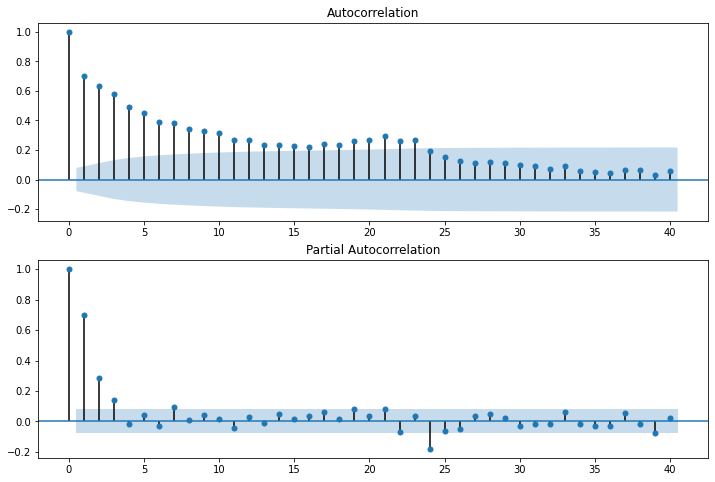

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_test.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_test.iloc[13:],lags=40,ax=ax2)

In [ ]:
X = df_test.values
Y = df_mp.values

train = Y[0:len(Y)]
test = X[0:len(X)]

history = [x for x in train]
predictions = list()

for t in range(len(test)):
  model = ARIMA(history, order=(1,1,2))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=116.313060, expected=102.333333
predicted=111.951912, expected=116.666667
predicted=113.415203, expected=112.666667
predicted=113.162324, expected=116.666667
predicted=114.180051, expected=110.000000
predicted=112.860835, expected=111.333333
predicted=112.419012, expected=118.666667
predicted=114.298601, expected=112.333333
predicted=113.622406, expected=110.000000
predicted=112.507753, expected=102.666667
predicted=109.643209, expected=108.666667
predicted=109.597211, expected=102.666667
predicted=107.799597, expected=109.000000
predicted=108.525969, expected=103.333333
predicted=107.314408, expected=111.000000
predicted=108.803902, expected=109.333333
predicted=109.253147, expected=107.666667
predicted=109.044632, expected=106.333333
predicted=108.518485, expected=108.666667
predicted=108.871177, expected=116.666667
predicted=111.448484, expected=105.333333
predicted=109.739533, expected=105.000000
predicted=108.559726, expected=106.000000
predicted=108.106309, expected=111

In [ ]:
prediction_df = pd.DataFrame(predictions,columns =['predicted AQI']) 
prediction_df

,predicted AQI
0,116.313060
1,111.951912
2,113.415203
3,113.162324
4,114.180051
...,...
626,100.526851
627,99.731288
628,98.331605
629,96.253176


In [ ]:
df2 = df2.reset_index(drop=True)
prediction_df = prediction_df.reset_index(drop=True)
result = pd.merge(left=df2,right=prediction_df, left_index=True, right_index=True)
result.tail(10)

,date,AQI,predicted AQI
621,16-05-20,87.0,94.962940
622,17-05-20,88.0,93.881140
623,18-05-20,95.0,93.492984
624,19-05-20,100.0,95.333725
625,20-05-20,103.0,97.976806
626,21-05-20,95.0,100.526851
627,22-05-20,92.0,99.731288
628,23-05-20,88.0,98.331605
629,24-05-20,87.0,96.253176
630,25-05-20,85.0,94.643052


Mean Squared Error

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 60.952


Root Mean Square Error

In [ ]:
rmse = sqrt(error)
print('Root Mean Squared Error: %.3f' % rmse)

Root Mean Squared Error: 7.807


Mean Absolute Error

In [ ]:
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

Test MAE: 5.268


Mean Absolute Percentage Error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(test,predictions)

4.590658584953369

Graph between Actual Vs Predicted AQI

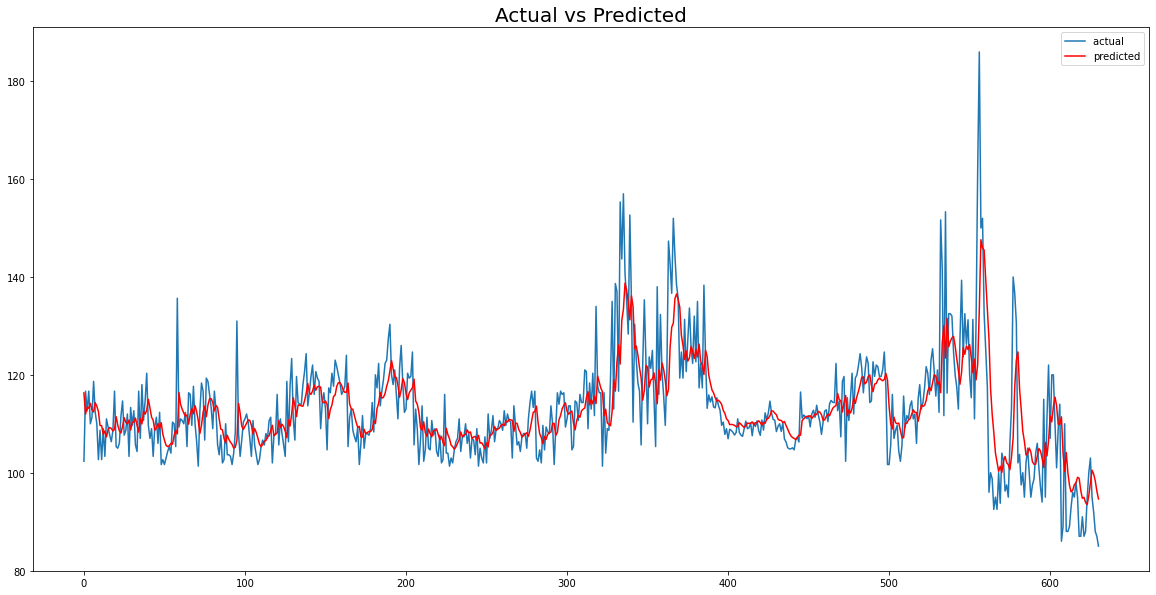

In [ ]:
# plot
fig= plt.figure(figsize=(20,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("Actual vs Predicted",fontsize=20)
plt.legend(["actual ","predicted"])
plt.show()